<a href="https://colab.research.google.com/github/promitdutta-biz/data_analyst_projects/blob/main/Bengaluru_Real_Estate_GH1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
!pip install shap
import shap

In [ ]:
path= "/content/drive/MyDrive/data_science_proj/datasets_20710_26737_Bengaluru_House_Data.csv"
df = pd.read_csv(path)
df.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00

sources:

https://www.magicbricks.com/blog/what-is-carpet-area/114783.html

https://civilread.com/plot-builtup-plinth-setback-carpet-super-builtup-area/#:~:text=The%20area%20which%20is%20surrounded,termed%20as%20a%20Plot%20area.

A **carpet area** is an area that can be covered by carpet, or a net usable area is called a carpet area.

The **built-up area** of a premise is measured from the external perimeter wall surfaces.

Built-up area = Carpet area + area of walls+area of balcony

The **Super Built-up area** of a premise is the saleable area, which includes the carpet area, along with the terrace, balconies, areas occupied by walls, and areas occupied by common/shared construction (e.g. lift, stairs, etc.).

Super built-up area = Built-up area + common areas

The **Plot Area** is the area which is surrounded by a boundary line (fencing).

In [ ]:
(df['area_type'].value_counts(normalize=True)*100).round(2)

Super built-up  Area    65.99
Built-up  Area          18.15
Plot  Area              15.20
Carpet  Area             0.65
Name: area_type, dtype: float64

most of the data quoted here has area type as Super built-up  Area

[Text(0.5, 1.0, 'Price variation with area type')]

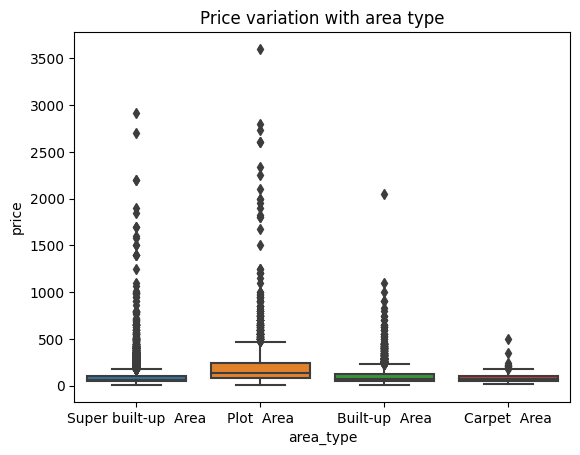

In [ ]:
sns.boxplot(x ='area_type', y ='price', data =df).set(title='Price variation with area type')

In [ ]:
df.groupby(by='area_type')['price'].mean().round(2).to_frame().sort_values(by=['price'])

price
area_type                   
Carpet  Area           89.50
Super built-up  Area   92.97
Built-up  Area        104.29
Plot  Area            208.50

In [ ]:
df.groupby(by='area_type')['price'].median().round(2).to_frame().sort_values(by=['price'])

price
area_type                  
Super built-up  Area   65.0
Built-up  Area         70.0
Carpet  Area           70.0
Plot  Area            140.0

It is also clearly seen from the mean and median analysis that the Plot area has got the highest price as it may be a standalone apartment or a house.

Let's fix the range of area (in sq. ft). We are taking the first observation in the range so as to negate any over statement by the builder or the authority who privided the data.

In [ ]:
def sqft_range_fix(df):
    if ("-" in df['total_sqft']):
        return float(df['total_sqft'].split("-")[0].strip())
    else:
        return df['total_sqft']
df['total_sqft_new'] = df.apply(sqft_range_fix, axis=1)
df.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price total_sqft_new  
0  Coomee        1056   2.0      1.0   39.07           1056  
1  Theanmp       2600   5.0      3.0  120.00           2600  
2      NaN       1440   2.0      3.0   62.00           1440  
3  Soiewre       1521   3.0      1.0   95.00           1521  
4      NaN       1200   2.0      1.0   51.00           1200

Now, we will convert all the units into sq. ft. There are many observations where the units are in sq. metre, acres and many locally used units like Guntha etc. Making all the units into sq. ft will ease the comparison.

In [ ]:
def sq_ft_correction(df):
    if ("Sq. Meter" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Sq. Meter",''))*10.7639
    if ("Sq. Yards" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Sq. Yards",''))*9
    if ("Perch" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Perch",''))*272.25
    if ("Acres" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Acres",''))*43560
    if ("Cents" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Cents",''))*435.6
    if ("Guntha" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Guntha",''))*1089
    if ("Grounds" in str(df['total_sqft_new'])):
        return float(df['total_sqft_new'].replace("Grounds",''))*2400.35

    else:
        return df['total_sqft_new']

df['area_sqft']=df.apply(sq_ft_correction,axis=1)
df.drop(['total_sqft','total_sqft_new'],axis=1,inplace=True)
df.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society  bath  balcony   price area_sqft  
0  Coomee    2.0      1.0   39.07      1056  
1  Theanmp   5.0      3.0  120.00      2600  
2      NaN   2.0      3.0   62.00      1440  
3  Soiewre   3.0      1.0   95.00      1521  
4      NaN   2.0      1.0   51.00      1200

In [ ]:
df['area_sqft'] = df['area_sqft'].astype('float', errors='raise')
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
bath            float64
balcony         float64
price           float64
area_sqft       float64
dtype: object

In [ ]:
df.groupby(by='area_type')['area_sqft'].mean().round(2).to_frame().sort_values(by=['area_sqft'])

area_sqft
area_type                      
Carpet  Area            1290.20
Super built-up  Area    1481.09
Built-up  Area          2108.86
Plot  Area              3551.58

This also shows that the Plot Area is the ones with large area values.

In [ ]:
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
bath            float64
balcony         float64
price           float64
area_sqft       float64
dtype: object

In [ ]:
#lets change the data types
df['area_sqft']=df['area_sqft'].astype('float',errors='ignore')
df['bath']=df['bath'].astype('int',errors='ignore')
df['balcony']=df['balcony'].astype('int',errors='ignore')

df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
bath            float64
balcony         float64
price           float64
area_sqft       float64
dtype: object

In [ ]:
df['price_per_sqft']= (df['price']*100000/df['area_sqft']).round(2)

In [ ]:
df.shape

(13320, 10)

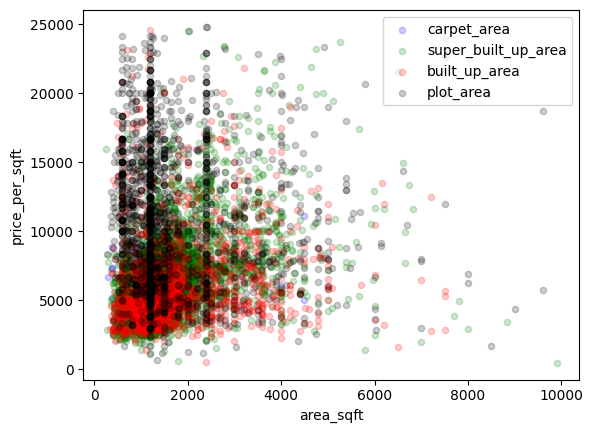

In [ ]:
ax = df[(df['area_type']=='Carpet  Area')&(df['price_per_sqft']<25000)&(df['area_sqft']<10000)].plot(kind= 'scatter', x="area_sqft", y="price_per_sqft",
             color= 'blue', label = 'carpet_area',alpha=0.2)
df[(df['area_type']=='Super built-up  Area')&(df['price_per_sqft']<25000)&(df['area_sqft']<10000)].plot(kind='scatter', x="area_sqft", y="price_per_sqft",
         color= 'green', label='super_built_up_area',alpha=0.2,ax=ax)
df[(df['area_type']=='Built-up  Area')&(df['price_per_sqft']<25000)&(df['area_sqft']<10000)].plot(kind='scatter', x="area_sqft", y="price_per_sqft",
         color= 'red', label='built_up_area',alpha=0.2,ax=ax)
df[(df['area_type']=='Plot  Area')&(df['price_per_sqft']<25000)&(df['area_sqft']<10000)].plot(kind='scatter', x="area_sqft", y="price_per_sqft",
         color= 'black', label='plot_area',alpha=0.2,ax=ax)
plt.xlabel('area_sqft')
plt.ylabel('price_per_sqft')
plt.legend()
plt.show()

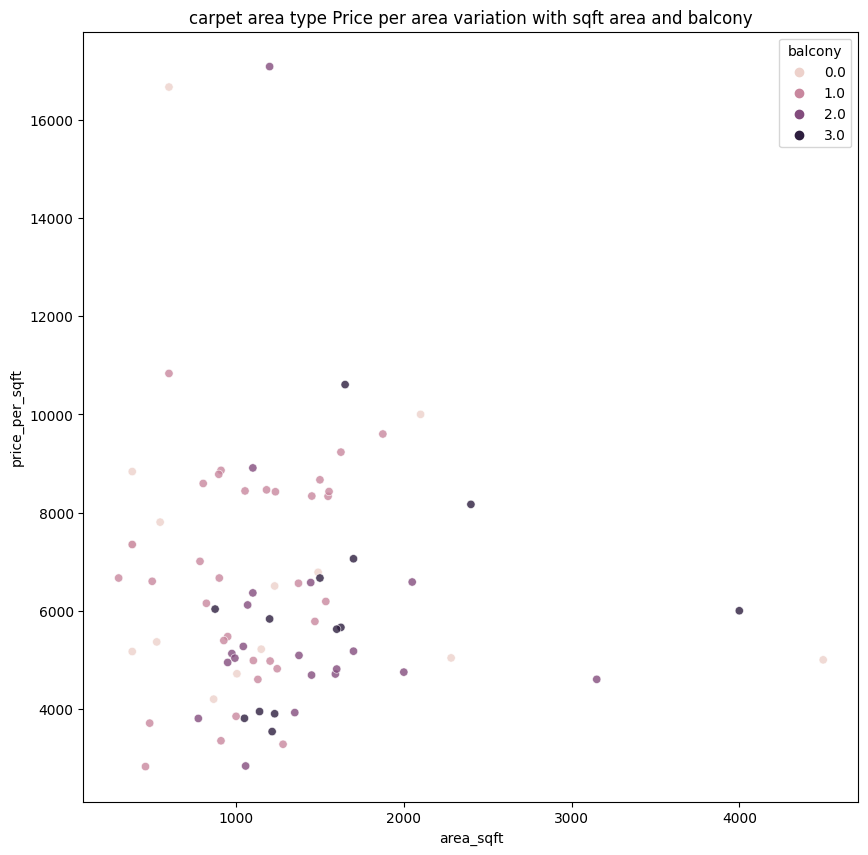

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Carpet  Area')],
                x='area_sqft', y='price_per_sqft',hue='balcony', alpha=0.8, ax= ax).set(title='carpet area type Price per area variation with sqft area and balcony')
plt.show()

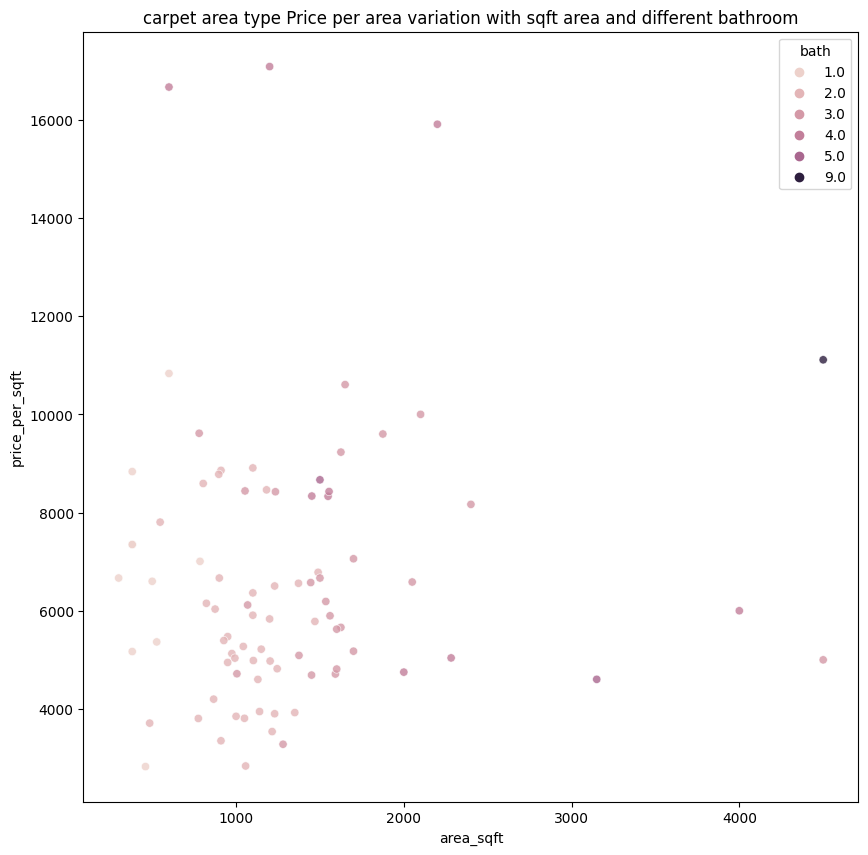

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Carpet  Area')],
                x='area_sqft', y='price_per_sqft',hue='bath', alpha=0.8, ax= ax).set(title='carpet area type Price per area variation with sqft area and different bathroom')
plt.show()

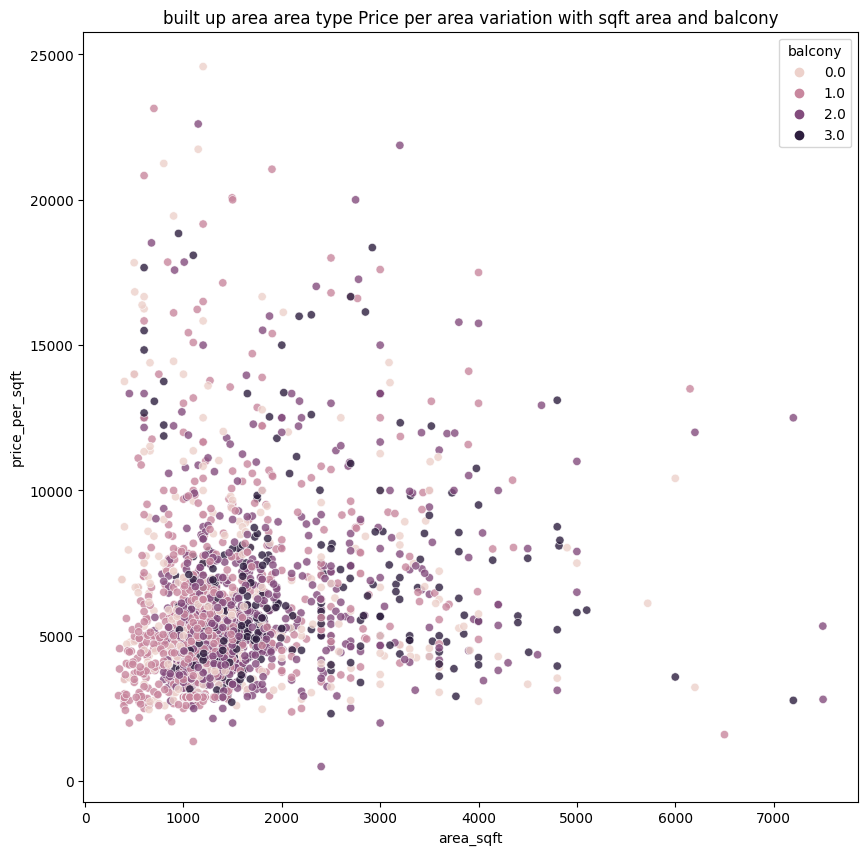

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Built-up  Area')],
                x='area_sqft', y='price_per_sqft',hue='balcony', alpha=0.8, ax= ax).set(title='built up area area type Price per area variation with sqft area and balcony')
plt.show()

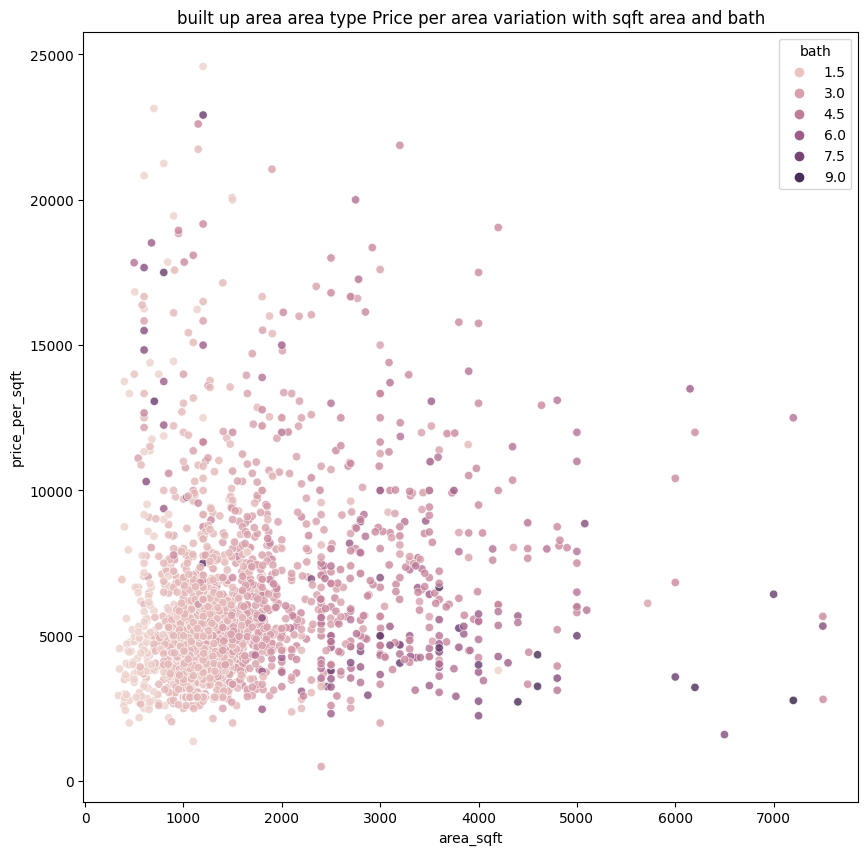

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Built-up  Area')],
                x='area_sqft', y='price_per_sqft',hue='bath', alpha=0.8, ax= ax).set(title='built up area area type Price per area variation with sqft area and bath')
plt.show()

most of the properties built up area area type has price per sqft within 10,000 rupee and area within 2000 sqft.

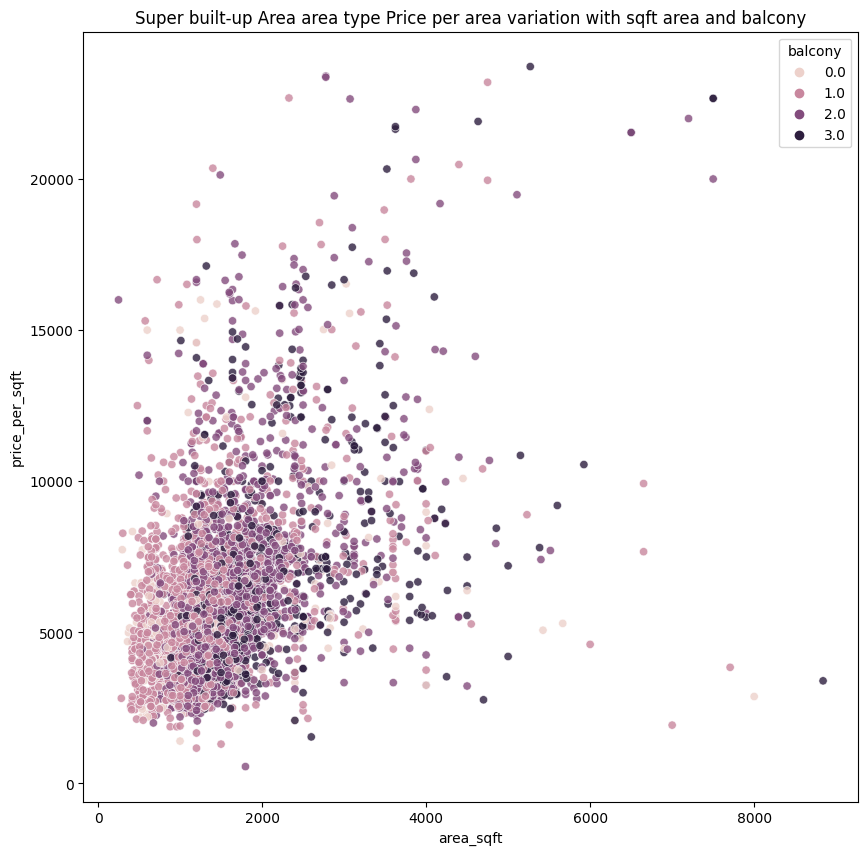

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Super built-up  Area')],
                x='area_sqft', y='price_per_sqft',hue='balcony', alpha=0.8, ax= ax).set(title='Super built-up Area area type Price per area variation with sqft area and balcony')
plt.show()

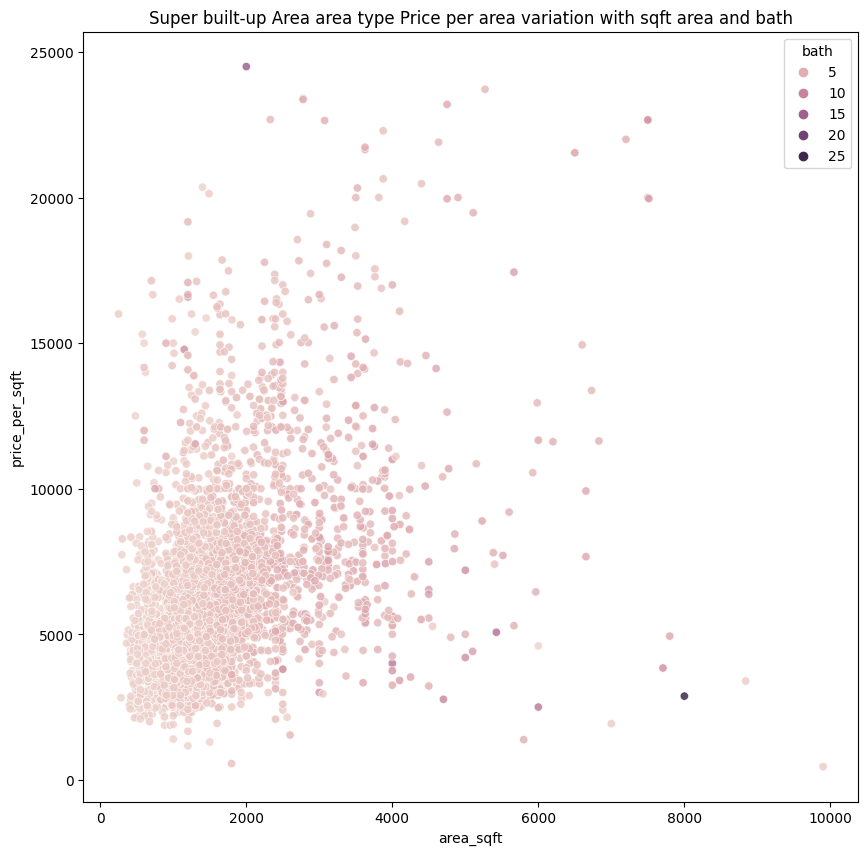

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Super built-up  Area')],
                x='area_sqft', y='price_per_sqft',hue='bath', alpha=0.8, ax= ax).set(title='Super built-up Area area type Price per area variation with sqft area and bath')
plt.show()

Most of the Super built up area properties have less than 10000 rupee per sq ft and 3000 sq ft.

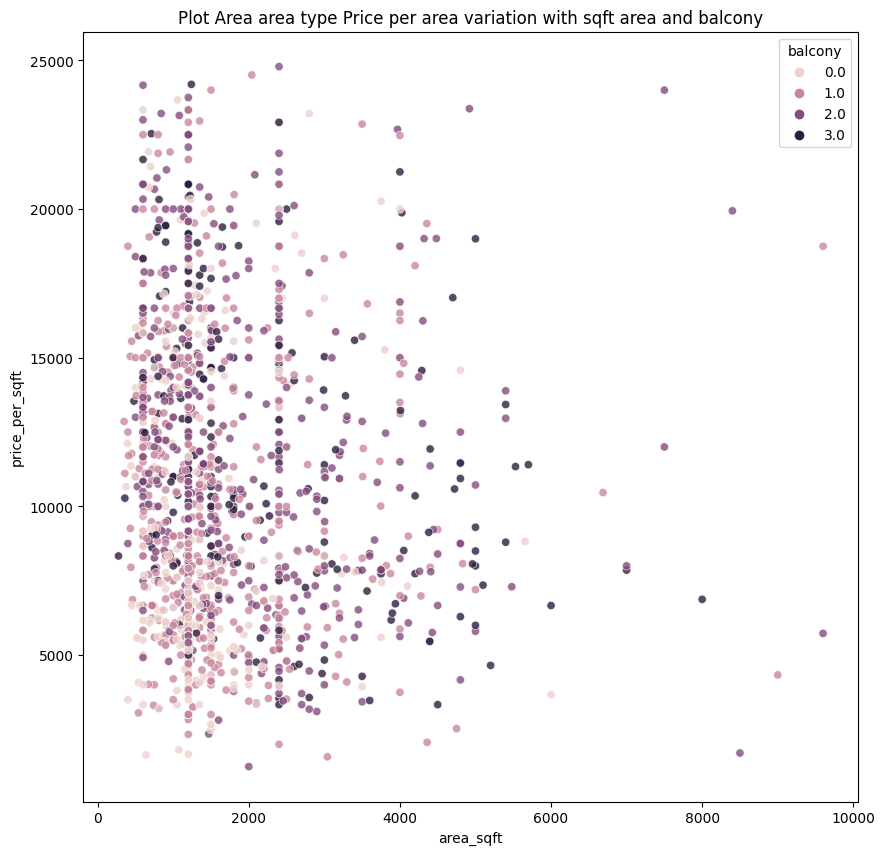

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Plot  Area')],
                x='area_sqft', y='price_per_sqft',hue='balcony', alpha=0.8, ax= ax).set(title='Plot Area area type Price per area variation with sqft area and balcony')
plt.show()

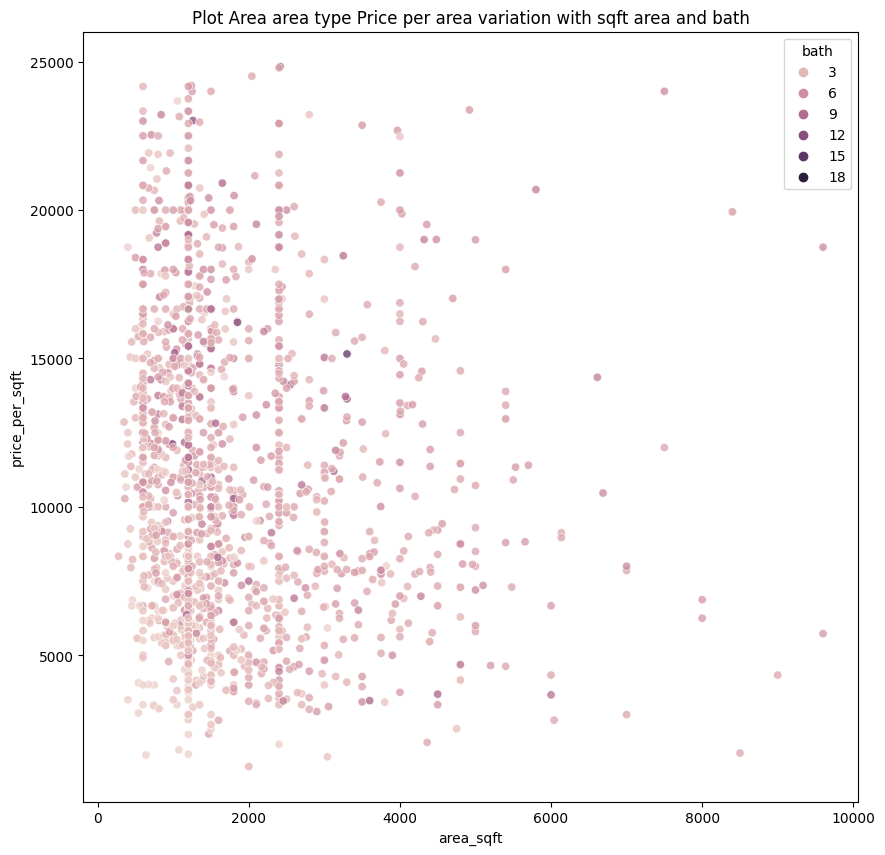

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[(df['price_per_sqft']<25000)&(df['area_sqft']<10000)&(df['area_type']=='Plot  Area')],
                x='area_sqft', y='price_per_sqft',hue='bath', alpha=0.8, ax= ax).set(title='Plot Area area type Price per area variation with sqft area and bath')
plt.show()

Plot area type properties have evenly distributed price per sqft across ranges between 5000 - 15000 rupee per sq ft.

We can notice that the Super built up area type properties are within the 10000 rupee per sqft and below 4000 sqft area.

The higher price per sqft properties are the properties with carpet area and plot area.

Now, let's define the number of bedrooms from the size columns. The number before the BHK is the number of bedrooms.

In [ ]:
def size_converter(df):
    if ("Bedroom" in str(df['size'])):
        return df['size'].replace("Bedroom", " ")
    if ("BHK" in str(df['size'])):
        return df['size'].replace("BHK", " ")
    else:
        return df['size']

df['bedrooms'] = df.apply(size_converter, axis=1)
df.drop(df[(df['size'] =='1 RK')].index, inplace=True) # we are excluding the RK properties
df.drop(['size','society'], axis=1, inplace=True) # society are excluded from analysis as it will make the model overfit
df.head()

area_type   availability                  location  bath  \
0  Super built-up  Area         19-Dec  Electronic City Phase II   2.0   
1            Plot  Area  Ready To Move          Chikka Tirupathi   5.0   
2        Built-up  Area  Ready To Move               Uttarahalli   2.0   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli   3.0   
4  Super built-up  Area  Ready To Move                  Kothanur   2.0   

   balcony   price  area_sqft  price_per_sqft bedrooms  
0      1.0   39.07     1056.0         3699.81      2    
1      3.0  120.00     2600.0         4615.38      4    
2      3.0   62.00     1440.0         4305.56      3    
3      1.0   95.00     1521.0         6245.89      3    
4      1.0   51.00     1200.0         4250.00      2

In [ ]:
df.drop('price_per_sqft',axis=1, inplace=True)

In [ ]:
# lets check for any null values
(df.isna().sum()*100/df.shape[0]).round(2)

area_type       0.00
availability    0.00
location        0.01
bath            0.55
balcony         4.58
price           0.00
area_sqft       0.00
bedrooms        0.12
dtype: float64

In [ ]:
#so we can drop those null rows which will not affect the data quality
df.dropna(inplace=True)

Let's calculate the days to move into the flat. The availability may be a factor in deciding the price. The reference is set at 1st Jan.

In [ ]:
import datetime
def waiting_days(df):
    if str(df['availability']) == 'Ready To Move':
        return 0
    if str(df['availability']) == 'Immediate Possession':
        return 0
    else :
        d1 = datetime.datetime.strptime(df['availability'], "%d-%b")
        d2 = datetime.datetime.strptime('01-Jan', "%d-%b")
        delta= (d1-d2).days
        return delta
df['waiting_days']= df.apply(waiting_days, axis=1)
df.drop('availability',axis=1,inplace=True)
df.head()

area_type                  location  bath  balcony   price  \
0  Super built-up  Area  Electronic City Phase II   2.0      1.0   39.07   
1            Plot  Area          Chikka Tirupathi   5.0      3.0  120.00   
2        Built-up  Area               Uttarahalli   2.0      3.0   62.00   
3  Super built-up  Area        Lingadheeranahalli   3.0      1.0   95.00   
4  Super built-up  Area                  Kothanur   2.0      1.0   51.00   

   area_sqft bedrooms  waiting_days  
0     1056.0      2             352  
1     2600.0      4               0  
2     1440.0      3               0  
3     1521.0      3               0  
4     1200.0      2               0

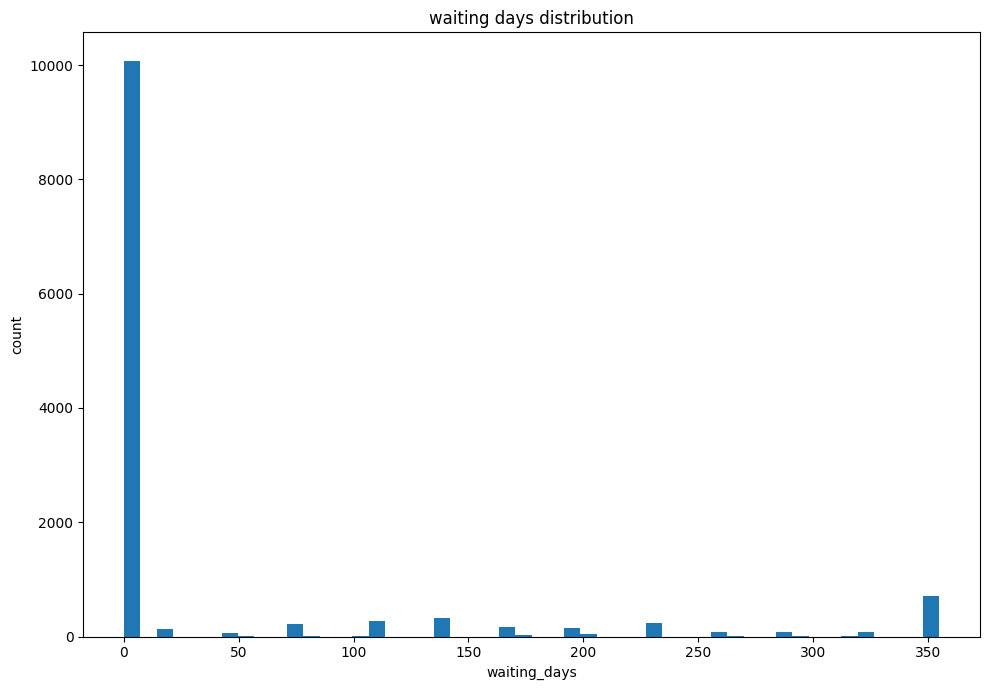

In [ ]:
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs.hist(df['waiting_days'], bins = 50)

plt.xlabel("waiting_days")
plt.ylabel("count")
plt.title('waiting days distribution')
# Show plot
plt.show()

we can see that most of the cases, the flats are available as ready to move in status.

[Text(0.5, 1.0, 'Price variation with waiting days')]

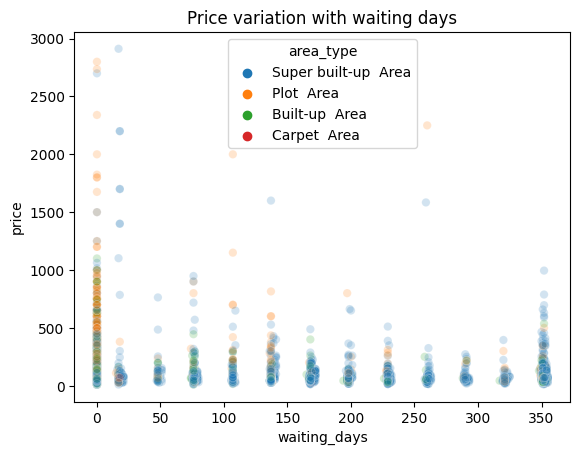

In [ ]:
sns.scatterplot(data=df,x='waiting_days', y='price',hue='area_type', alpha=0.2).set(title='Price variation with waiting days')

So we can see that price is higher for the area type 'Plot Area' and most of them are readily available. Here, in most of the cases the area_type is of Super built-up Area.

We will now get the top 50 locations where the data is coming from. This will reduce the locations columns after one hot encoding. The less number in location columns will make the model more generalize.

In [ ]:
top50_locations = (df['location'].value_counts(normalize=True)*100).to_frame().head(50)
top50_locations.reset_index(inplace=True)
top50_locations.columns=['location','loc_count_share']
loc_list=top50_locations['location'].unique().tolist()

In [ ]:
#let's tryy with generalize location tags
def loc_tag(df):
    if df['location'] in loc_list:
        return df['location']
    else:
        return 'others'

df['loc_tag']=df.apply(loc_tag, axis=1)
df.head(10)

area_type                  location  bath  balcony   price  \
0   Super built-up  Area  Electronic City Phase II   2.0      1.0   39.07   
1             Plot  Area          Chikka Tirupathi   5.0      3.0  120.00   
2         Built-up  Area               Uttarahalli   2.0      3.0   62.00   
3   Super built-up  Area        Lingadheeranahalli   3.0      1.0   95.00   
4   Super built-up  Area                  Kothanur   2.0      1.0   51.00   
5   Super built-up  Area                Whitefield   2.0      1.0   38.00   
8   Super built-up  Area              Marathahalli   3.0      1.0   63.25   
10  Super built-up  Area                Whitefield   2.0      2.0   70.00   
11            Plot  Area                Whitefield   5.0      3.0  295.00   
12  Super built-up  Area        7th Phase JP Nagar   2.0      1.0   38.00   

    area_sqft bedrooms  waiting_days                   loc_tag  
0      1056.0      2             352  Electronic City Phase II  
1      2600.0      4               0                    others  
2      1440.0      3               0               Uttarahalli  
3      1521.0      3               0                    others  
4      1200.0      2               0                  Kothanur  
5      1170.0      2               0                Whitefield  
8      1310.0      3               0              Marathahalli  
10     1800.0      3              48                Whitefield  
11     2785.0      4               0                Whitefield  
12     1000.0      2               0        7th Phase JP Nagar

In [ ]:
#let's refine the location list while removing adjectives such as Nagar, Layout etc
unique_string = (" ").join(loc_list)
repeated_adj_locaton = ['Nagar','Layout', 'City', 'Phase', 'Stage', 'Road', 'Old', 'nagar', 'Town', 'Sector',
                        'II', '2nd', '7th', '1', '8th', 'New', 'Gate', '9th', '5th', 'Area', 'III', '1st', '6th', '-', 'VI', 'East', '2', '7']
for i in repeated_adj_locaton:
    unique_string = unique_string.replace(i," ")

In [ ]:
from nltk import FreqDist
words = unique_string.split()
fdist1 = FreqDist(words)
#print(fdist1)
L=[]
for i in range(0,len(fdist1.most_common())):
    L.append(fdist1.most_common()[i][0])

Let's build a word cloud for the top 50 locations. It gives a high level visual understanding on the locations which contributed into this data.

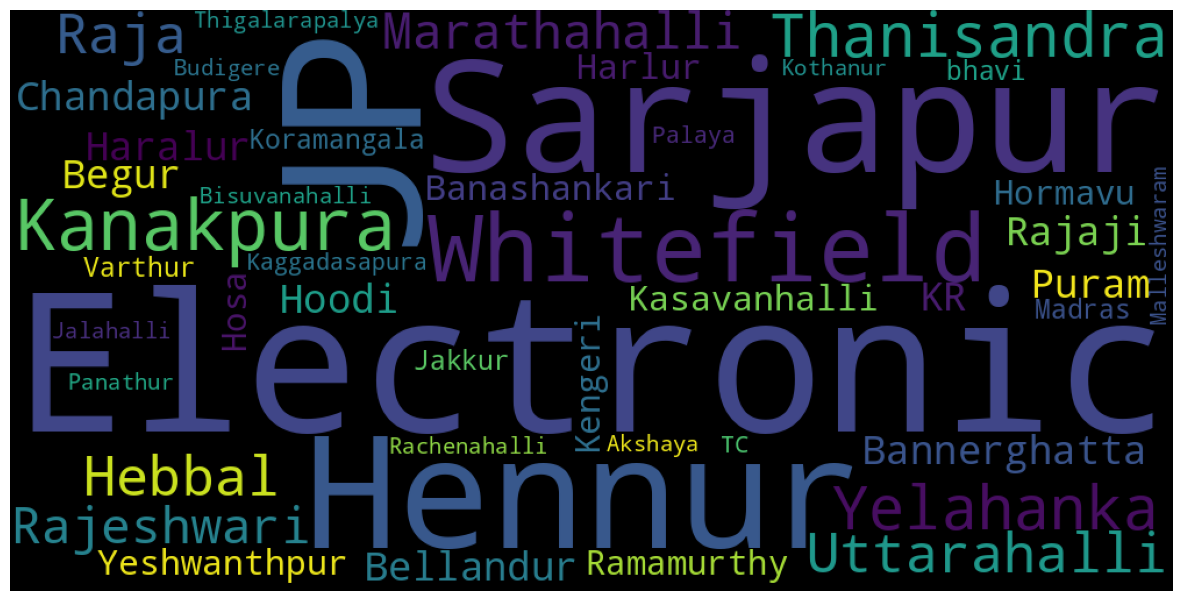

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
def loc_tag_refine(df):
    for i in range(0,len(L)):
        if L[i] in df['location']:
            return L[i]
            break
df['loc_tag_new']=df.apply(loc_tag_refine, axis=1)
df.head()

area_type                  location  bath  balcony   price  \
0  Super built-up  Area  Electronic City Phase II   2.0      1.0   39.07   
1            Plot  Area          Chikka Tirupathi   5.0      3.0  120.00   
2        Built-up  Area               Uttarahalli   2.0      3.0   62.00   
3  Super built-up  Area        Lingadheeranahalli   3.0      1.0   95.00   
4  Super built-up  Area                  Kothanur   2.0      1.0   51.00   

   area_sqft bedrooms  waiting_days                   loc_tag  loc_tag_new  
0     1056.0      2             352  Electronic City Phase II   Electronic  
1     2600.0      4               0                    others         None  
2     1440.0      3               0               Uttarahalli  Uttarahalli  
3     1521.0      3               0                    others         None  
4     1200.0      2               0                  Kothanur     Kothanur

In [ ]:
#let's check the uniques values counts in loc_tag
df['loc_tag'].value_counts()

others                      7009
Whitefield                   514
Sarjapur  Road               372
Electronic City              300
Kanakpura Road               261
Thanisandra                  231
Yelahanka                    206
Uttarahalli                  186
Hebbal                       173
Raja Rajeshwari Nagar        168
Marathahalli                 164
7th Phase JP Nagar           147
Bannerghatta Road            144
Hennur Road                  142
Haralur Road                 135
Electronic City Phase II     130
Rajaji Nagar                  99
Chandapura                    98
Bellandur                     91
Hoodi                         86
Electronics City Phase 1      85
KR Puram                      85
Begur Road                    83
Sarjapur                      81
Yeshwanthpur                  78
Kasavanhalli                  77
Harlur                        76
Banashankari                  74
Ramamurthy Nagar              72
Hosa Road                     72
Hormavu   

In [ ]:
#let's check the uniques values counts in loc_tag_new after refinement
df['loc_tag_new'].value_counts()

Electronic        523
Whitefield        519
Sarjapur          483
JP                402
Raja              289
Kanakpura         261
Yelahanka         256
Thanisandra       238
Hennur            207
Hebbal            201
Uttarahalli       186
Marathahalli      164
Bannerghatta      161
Banashankari      158
Haralur           136
Hosa              129
Kengeri           116
Koramangala       103
Begur              99
Chandapura         98
Hoodi              95
KR                 93
Bellandur          92
bhavi              89
Varthur            85
Yeshwanthpur       80
Jakkur             80
Kasavanhalli       77
Ramamurthy         77
Harlur             76
Akshaya            76
Jalahalli          72
Hormavu            71
Madras             69
TC                 63
Kaggadasapura      61
Thigalarapalya     60
Kothanur           59
Rachenahalli       54
Budigere           54
Malleshwaram       52
Panathur           52
Bisuvanahalli      51
Palaya             28
Puram              10
Name: loc_

In [ ]:
df.drop('loc_tag', axis=1, inplace=True)
df.rename(columns = {'loc_tag_new':'loc_tag'}, inplace = True)
df['loc_tag'].fillna('other',inplace=True)
# after refinement the location tag becomes as follows
df.head()

area_type                  location  bath  balcony   price  \
0  Super built-up  Area  Electronic City Phase II   2.0      1.0   39.07   
1            Plot  Area          Chikka Tirupathi   5.0      3.0  120.00   
2        Built-up  Area               Uttarahalli   2.0      3.0   62.00   
3  Super built-up  Area        Lingadheeranahalli   3.0      1.0   95.00   
4  Super built-up  Area                  Kothanur   2.0      1.0   51.00   

   area_sqft bedrooms  waiting_days      loc_tag  
0     1056.0      2             352   Electronic  
1     2600.0      4               0        other  
2     1440.0      3               0  Uttarahalli  
3     1521.0      3               0        other  
4     1200.0      2               0     Kothanur

In [ ]:
#df['loc_tag'].value_counts().to_frame().to_csv('temp.csv')
df['area_type'].replace(' ','_',regex=True,inplace=True)
df['area_type'].value_counts()

Super_built-up__Area    8472
Built-up__Area          2306
Plot__Area              1837
Carpet__Area              82
Name: area_type, dtype: int64

<Axes: xlabel='price', ylabel='Count'>

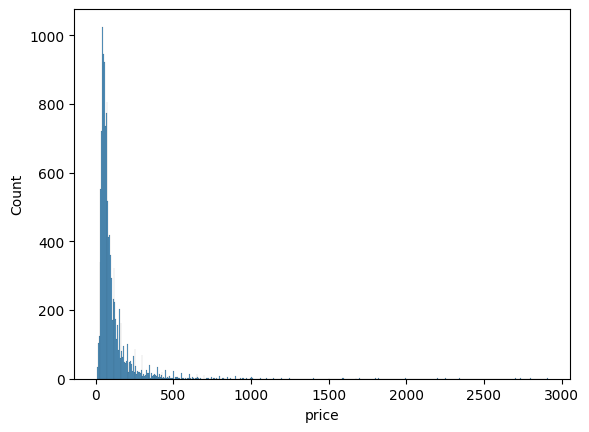

In [ ]:
#let's plot the histogram to see the price distribution
sns.histplot(data=df['price'])

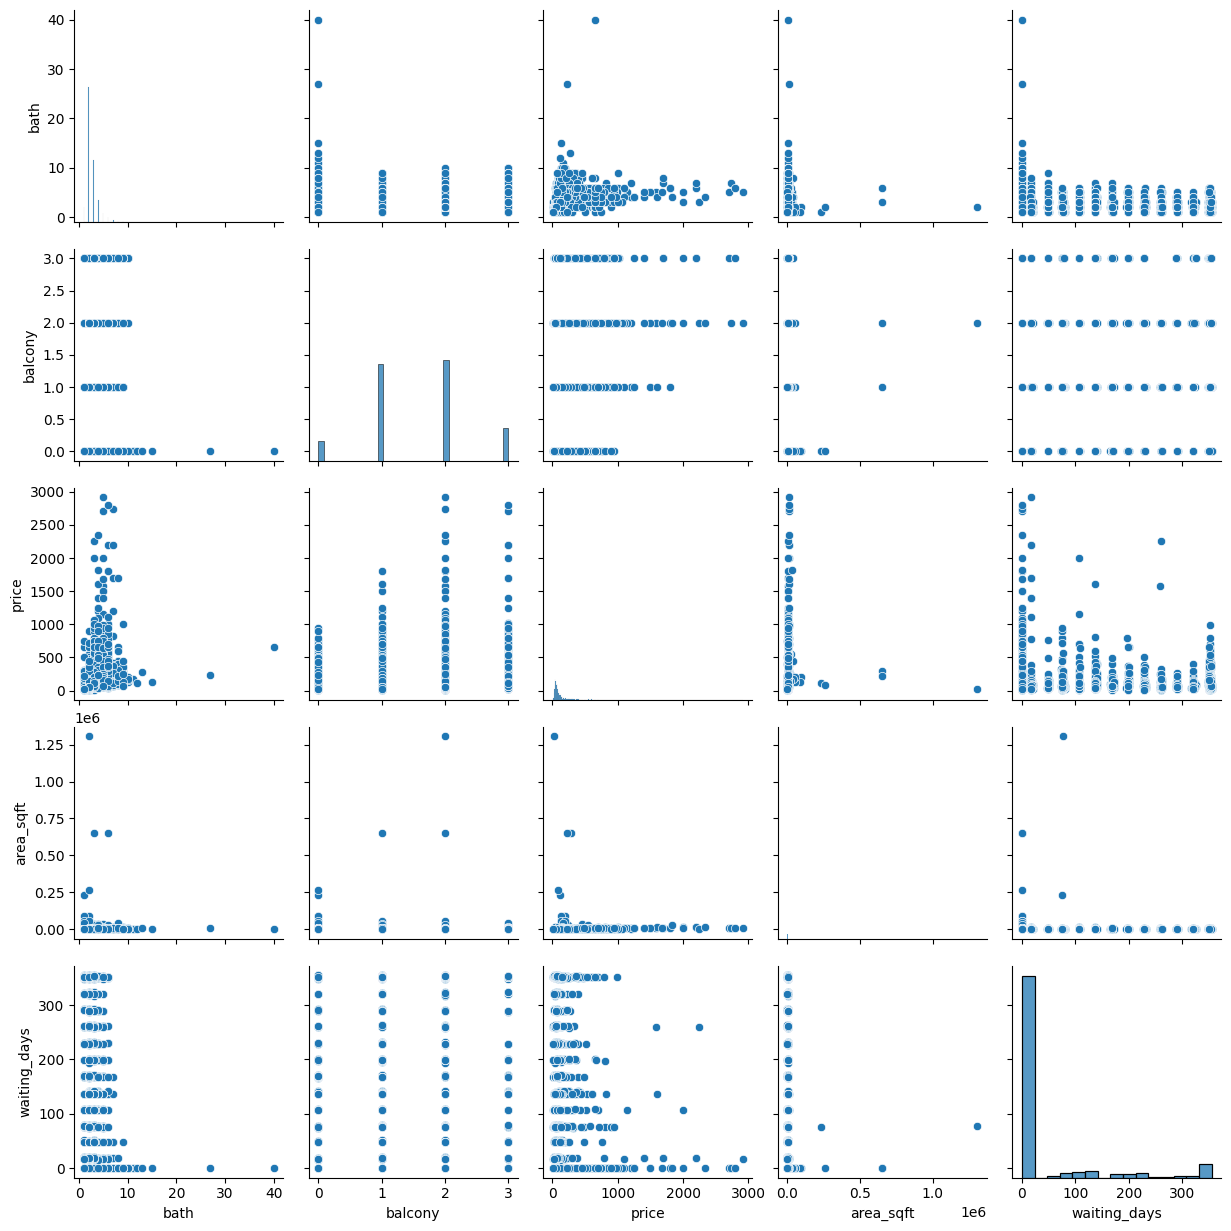

In [ ]:
sns.pairplot(df)

Some important points to note from this pairplot:

Adding bathrooms is not adding price to the flats.

Bathrooms and bedrooms are linearly correlated with positive correlation.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

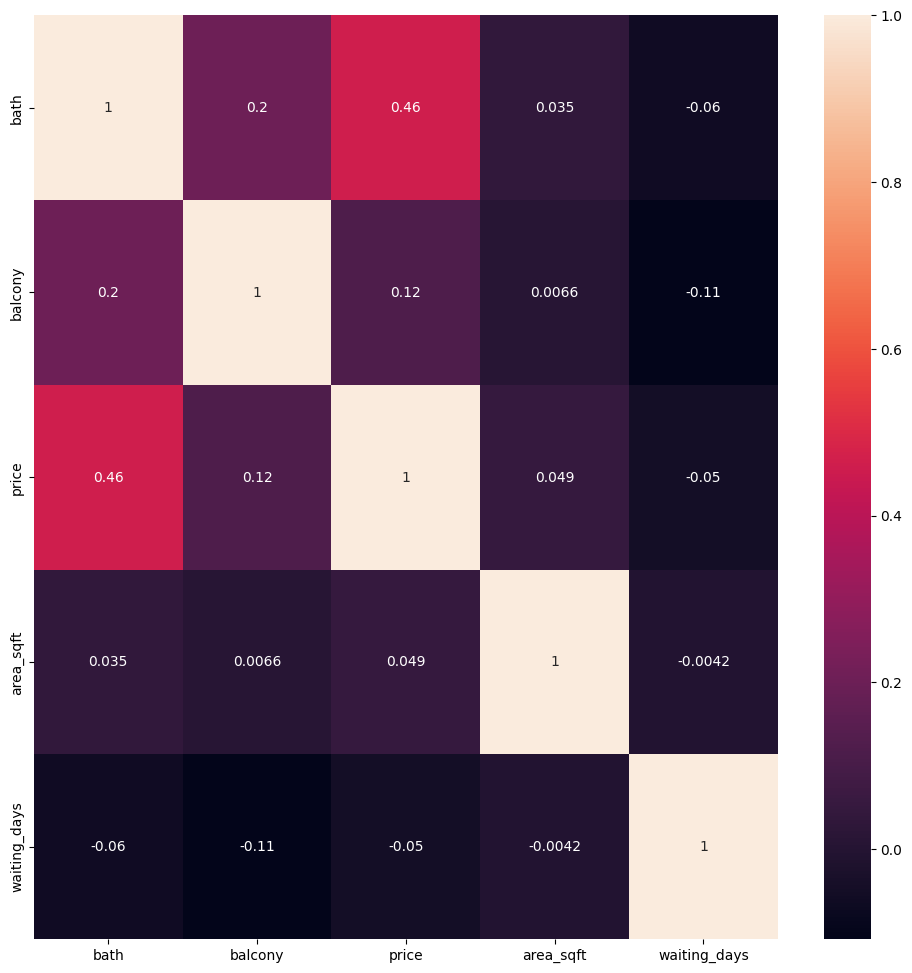

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True)

There is no significant negative correlation, as such. Bathrooms and bedrooms are correlalted with correlation coefficient +0.89 which is quite normal.

In [ ]:
df['bedrooms']=df['bedrooms'].astype('int',errors='ignore')

We have 9 columns, 6 of which are numerical.


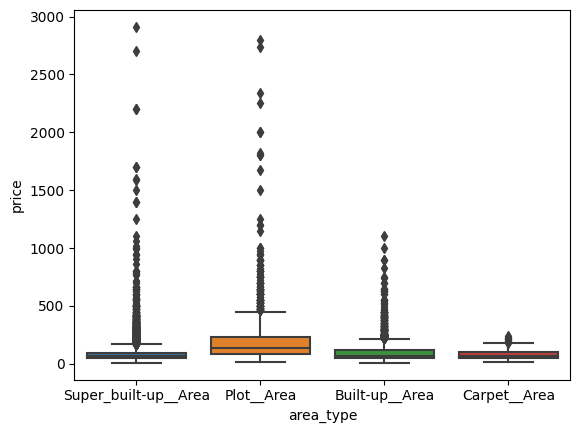

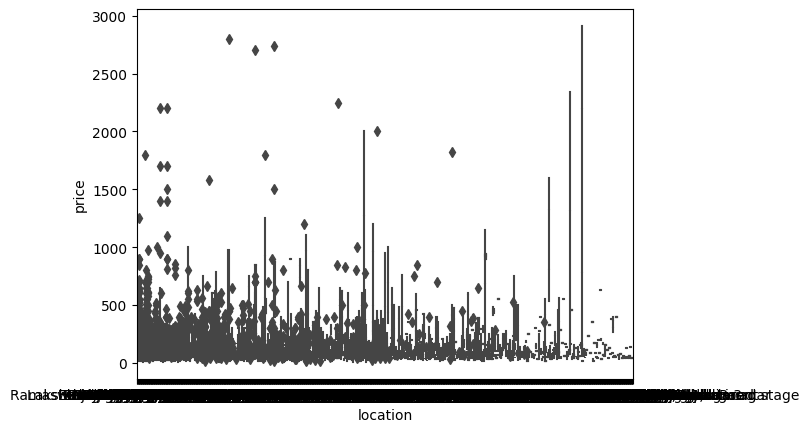

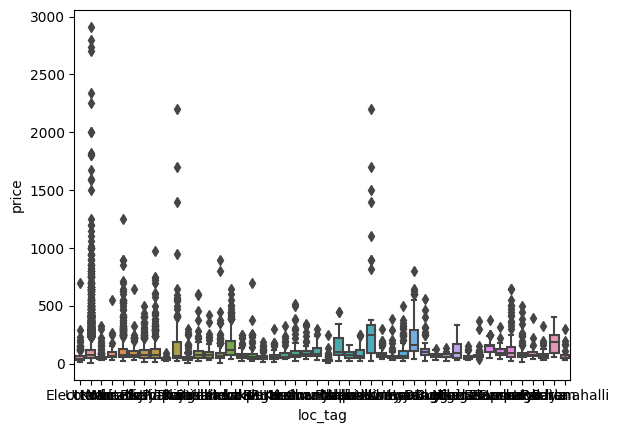

In [ ]:
num_columns = df.select_dtypes(include=np.number) #numerical columns
cat_columns = df.select_dtypes(exclude=np.number) #categorical columns


print(f'We have {len(df.columns)} columns, {len(num_columns.columns)} of which are numerical.')

features_to_analyse = cat_columns
for f in features_to_analyse:
    sns.boxplot(x=f, y='price', data=df)
    plt.show()

In [ ]:
df=df.drop('location',axis=1)
#df2=df.drop('loc_tag',axis=1).copy()

In [ ]:
#let's take a look at the dataframe
df.head()

area_type  bath  balcony   price  area_sqft  bedrooms  \
0  Super_built-up__Area   2.0      1.0   39.07     1056.0         2   
1            Plot__Area   5.0      3.0  120.00     2600.0         4   
2        Built-up__Area   2.0      3.0   62.00     1440.0         3   
3  Super_built-up__Area   3.0      1.0   95.00     1521.0         3   
4  Super_built-up__Area   2.0      1.0   51.00     1200.0         2   

   waiting_days      loc_tag  
0           352   Electronic  
1             0        other  
2             0  Uttarahalli  
3             0        other  
4             0     Kothanur

In [ ]:
#let's make the dependent and independent variables
X = df.drop(['price'],axis=1).copy()
y = df['price'].copy()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

In [ ]:
OHE_X = pd.get_dummies(X, columns= X.columns[X.dtypes=='object'].to_list(),drop_first=True) #one hot encoding for the categorical data
#split the data in train and test set
X_train, X_test, y_train, y_test = train_test_split(OHE_X, y, test_size = 0.2, random_state = 4)

We will now try different mamchine learning algorithms and report their results.

#Multiple Linear Regression

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
regr.coef_

array([ 4.55734277e+01,  9.26515680e+00,  1.94824994e-04, -6.02381165e+00,
        6.74743219e-03, -5.86161404e+00,  5.61396422e+01, -5.48237468e+00,
        2.83782835e+01,  1.20620241e+01, -2.04744019e+01,  6.10645976e+00,
       -4.65256976e+00, -8.76330877e-01, -2.02489003e+01, -8.21656347e+00,
        1.03287718e+00,  2.26656049e+01,  6.32192182e+01,  1.64666205e+01,
        5.17130905e+00,  1.21221733e+00,  1.17800773e+01,  1.25755903e+01,
        2.96330903e+01,  7.50897969e+00, -6.33009335e+00, -1.44533306e+01,
       -5.92899897e+00,  8.71619578e+00, -1.49219753e+01,  1.10896911e+02,
       -2.88204249e+00,  8.51451080e+00,  2.39932528e+02,  1.20998297e+01,
       -1.16732031e+01,  1.55555223e+01,  5.91586067e+01,  4.65428847e+00,
        6.44207875e+01, -2.68901439e+01,  2.45713496e+01, -3.28900575e+01,
        1.02297237e+01,  1.78821816e+01, -5.95581189e+00, -1.23320597e+01,
        3.22950588e+01,  9.59237897e+00,  2.32201754e+01,  1.50162107e+01,
        1.88902606e+01])

In [ ]:
y_hat= regr.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Residual sum of squares: 8041.08
Variance score: 0.32


In [ ]:
#let's find the R^2 value of this multiple linear rergression
#R^2 = 1-(RSS/TSS)
#RSS = sum(y-y_pred)^2
#TSS = sum(y-y_mean)^2
regr.score(X_test, y_test)

0.32233273733294254

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, regr.predict(X_test))
r2

0.32233273733294254

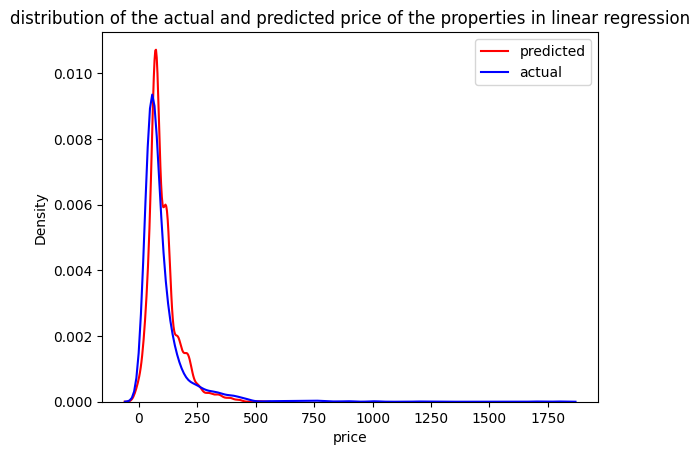

In [ ]:
ax1 = sns.kdeplot(y_hat, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the properties in linear regression")
plt.legend()
plt.show()

#Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
RM = Ridge(alpha=0.1)
RM.fit(X_train,y_train)
RM.score(X_test,y_test)

0.32229891812018285

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, RM.predict(X_test))
r2

0.32229891812018285

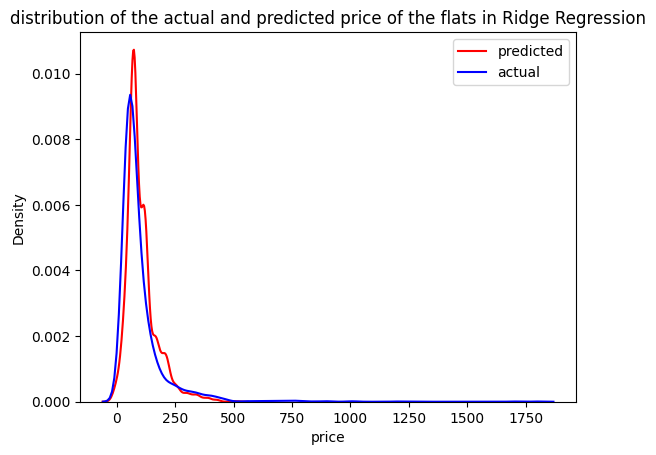

In [ ]:
y_hat = RM.predict(X_test)
ax1 = sns.kdeplot(y_hat, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the flats in Ridge Regression")
plt.legend()
plt.show()

#Decission Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

sklearn_dt = DecisionTreeRegressor(max_depth=4, random_state=4)
sklearn_dt.fit(X_train, y_train)

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)


# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 5548.105


In [ ]:
sklearn_dt.score(X_test,y_test)

0.5324297301713243

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, sklearn_dt.predict(X_test))
r2

0.5324297301713243

In [ ]:
import sklearn.tree as tree

plt.figure(figsize=(150,150))
tree.plot_tree(sklearn_dt)
plt.show()

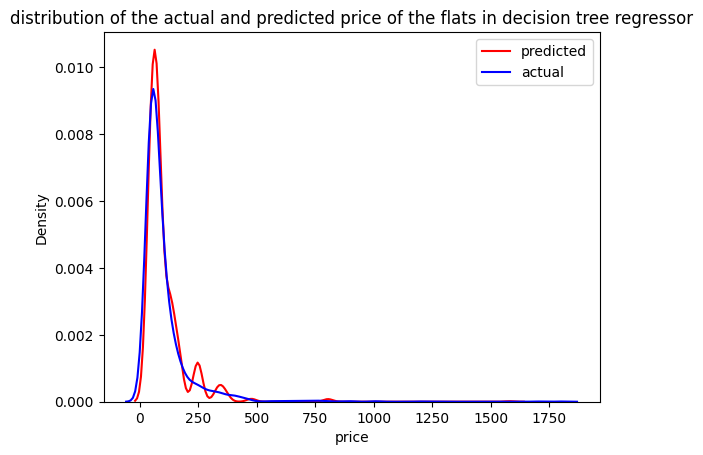

In [ ]:
ax1 = sns.kdeplot(sklearn_pred, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the flats in decision tree regressor")
plt.legend()
plt.show()

#Polynomial Ridge Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pr2 = PolynomialFeatures(degree=2)
RM=Ridge(alpha=0.1)
RM.fit(X_train, y_train)
RM.score(X_test,y_test)

0.32229891812018285

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, RM.predict(X_test))
r2

0.32229891812018285

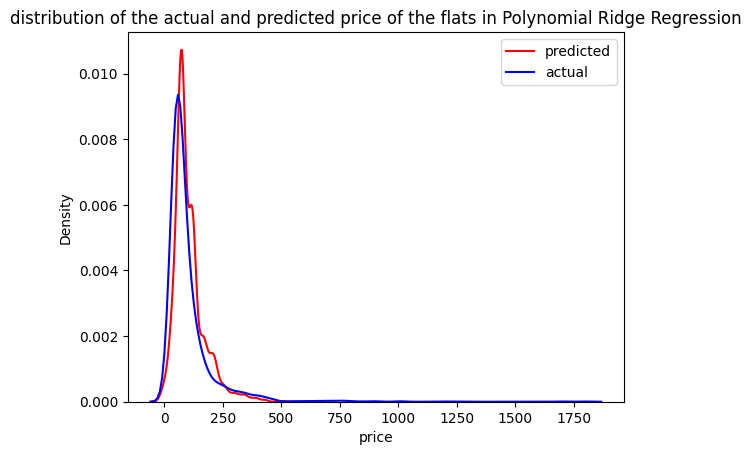

In [ ]:
y_hat = RM.predict(X_test)
ax1 = sns.kdeplot(y_hat, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the flats in Polynomial Ridge Regression")
plt.legend()
plt.show()

#RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 4)

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]
oob_score = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score' : oob_score}

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2, random_state=4, n_jobs = -1)
rf_random.fit(X_train, y_train)

# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits



110 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

One or more of the test scores are non-finite: [0.56734809 0.57658396 0.4158535         nan        nan 0.60528574
 0.33516594 0.4095498  0.5531848         nan 0.50748352 0.5

Best Parameters:  {'oob_score': False, 'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}  



In [ ]:
best_regressor = rf_random.best_estimator_
best_regressor

RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_split=10,
                      n_estimators=20, random_state=4)

In [ ]:
#let's calcuate the R^2 score for the model
best_regressor.score(X_test, y_test)

0.6760406647042891

In [ ]:
from sklearn.model_selection import cross_val_score

scores= cross_val_score(best_regressor, OHE_X, y ,cv=5) # scores on whole dataset
np.sqrt(scores).mean()*100, np.sqrt(scores).std()*100

(77.90354509041431, 2.409277501458398)

In [ ]:
from sklearn.model_selection import cross_val_score

scores= cross_val_score(best_regressor, X_test, y_test ,cv=5) #scores on test data set
np.sqrt(scores).mean()*100, np.sqrt(scores).std()*100

(73.47433039779584, 2.9988890693321455)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Get predictions
y_pred = best_regressor.predict(X_test)

# Calculate MAE
rmse_pred = mean_absolute_error(y_test, y_pred)

print("Root Mean Absolute Error:" , np.sqrt(rmse_pred))

Root Mean Absolute Error: 5.4236118084850835


In [ ]:
best_regressor.feature_names_in_

array(['bath', 'balcony', 'area_sqft', 'bedrooms', 'waiting_days',
       'area_type_Carpet__Area', 'area_type_Plot__Area',
       'area_type_Super_built-up__Area', 'loc_tag_Banashankari',
       'loc_tag_Bannerghatta', 'loc_tag_Begur', 'loc_tag_Bellandur',
       'loc_tag_Bisuvanahalli', 'loc_tag_Budigere', 'loc_tag_Chandapura',
       'loc_tag_Electronic', 'loc_tag_Haralur', 'loc_tag_Harlur',
       'loc_tag_Hebbal', 'loc_tag_Hennur', 'loc_tag_Hoodi',
       'loc_tag_Hormavu', 'loc_tag_Hosa', 'loc_tag_JP', 'loc_tag_Jakkur',
       'loc_tag_Jalahalli', 'loc_tag_KR', 'loc_tag_Kaggadasapura',
       'loc_tag_Kanakpura', 'loc_tag_Kasavanhalli', 'loc_tag_Kengeri',
       'loc_tag_Koramangala', 'loc_tag_Kothanur', 'loc_tag_Madras',
       'loc_tag_Malleshwaram', 'loc_tag_Marathahalli', 'loc_tag_Palaya',
       'loc_tag_Panathur', 'loc_tag_Puram', 'loc_tag_Rachenahalli',
       'loc_tag_Raja', 'loc_tag_Ramamurthy', 'loc_tag_Sarjapur',
       'loc_tag_TC', 'loc_tag_Thanisandra', 'loc_tag_Thi

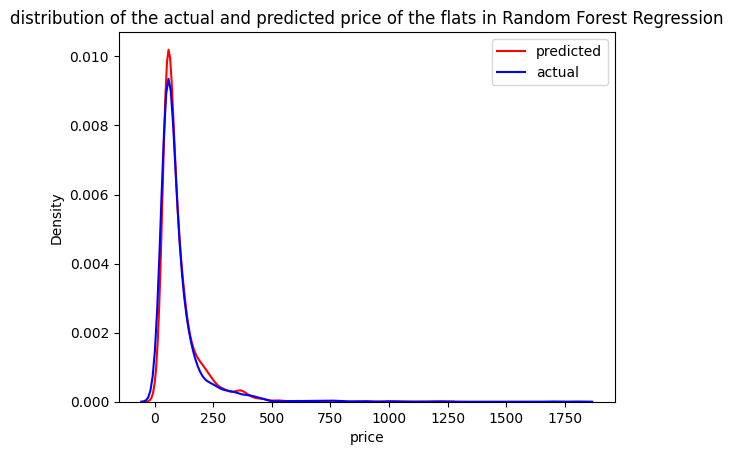

In [ ]:
y_hat = best_regressor.predict(X_test)
ax1 = sns.kdeplot(y_hat, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the flats in Random Forest Regression")
plt.legend()
plt.show()

#XGBoost Regression

In [ ]:
#parameters to test in XGB Regression
params = {
    'n_estimators':[500],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)]}

In [ ]:
reg = XGBRegressor()

# run randomized search
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=4)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      "parameter settings." %((time.time() - start), 100))

The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV took 285.11 seconds for 100 candidatesparameter settings.


In [ ]:
best_regressor = random_search.best_estimator_
best_regressor

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric='rmse',
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Get predictions
y_pred = best_regressor.predict(X_test)

# Calculate MAE
rmse_pred = mean_absolute_error(y_test, y_pred)

print("Root Mean Absolute Error:" , np.sqrt(rmse_pred))

Root Mean Absolute Error: 5.391802519563013


In [ ]:
#let's calcuate the R^2 score for the model
best_regressor.score(X_test, y_test)

0.6162108530290114

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, best_regressor.predict(X_test))
r2

0.6162108530290114

In [ ]:
pd.DataFrame(random_search.cv_results_).to_csv('param.csv')

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
rgr=random_search.best_estimator_

In [ ]:
scores= cross_val_score(rgr, OHE_X, y ,cv=5)
np.sqrt(scores).mean()*100, np.sqrt(scores).std()*100

(74.37632722209922, 4.832926799386249)

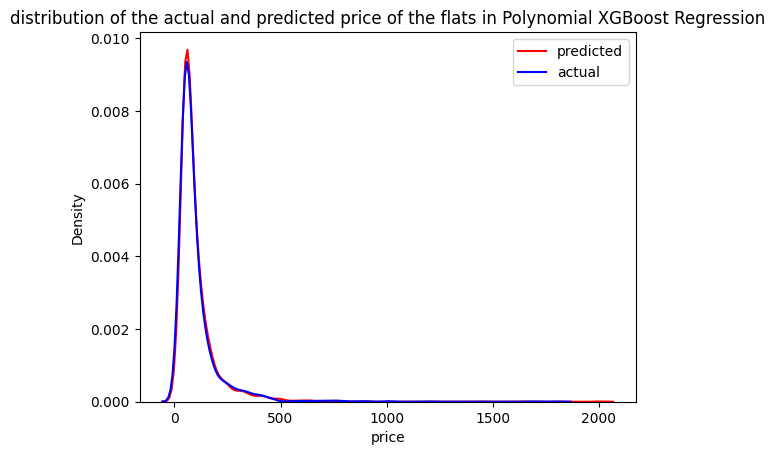

In [ ]:
y_hat = rgr.predict(X_test)
ax1 = sns.kdeplot(y_hat, color="r", label="predicted")
ax2 = sns.kdeplot(y_test, color="b", label="actual", ax= ax1).set_title("distribution of the actual and predicted price of the flats in Polynomial XGBoost Regression")
plt.legend()
plt.show()

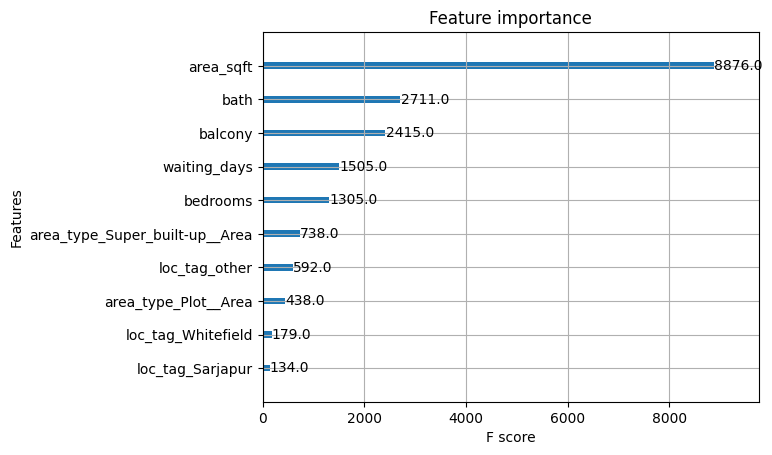

In [ ]:
%matplotlib inline
from xgboost import plot_importance
fit = random_search.best_estimator_.fit(OHE_X, y)
plot_importance(fit, max_num_features=10)
plt.show()

Here we can see the attributes which decide the magnitude of price with ordered importance. Area, bathrooms ,balconies are most influencial in pricing.

In [ ]:
model=random_search.best_estimator_

model.fit(OHE_X, y)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 2541it [05:28,  7.59it/s]


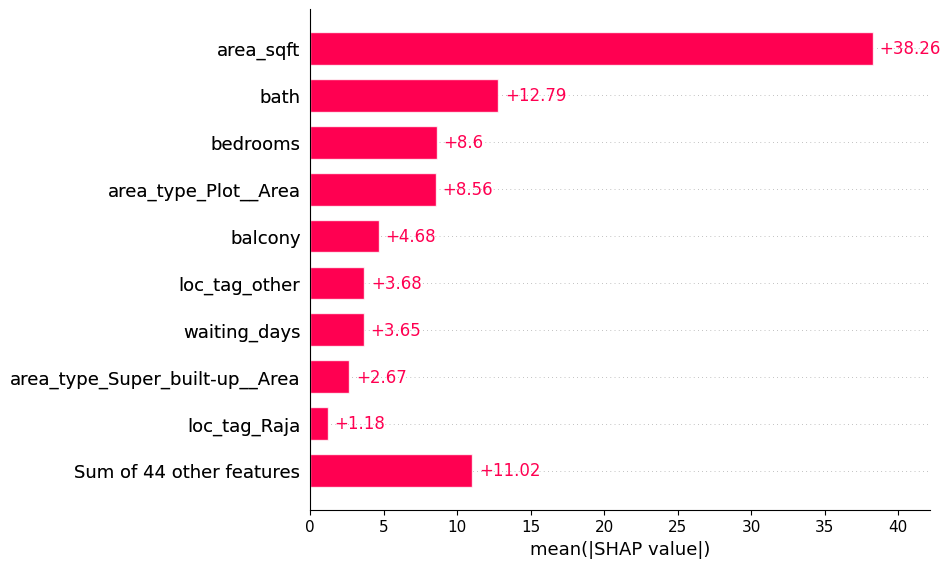

In [ ]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


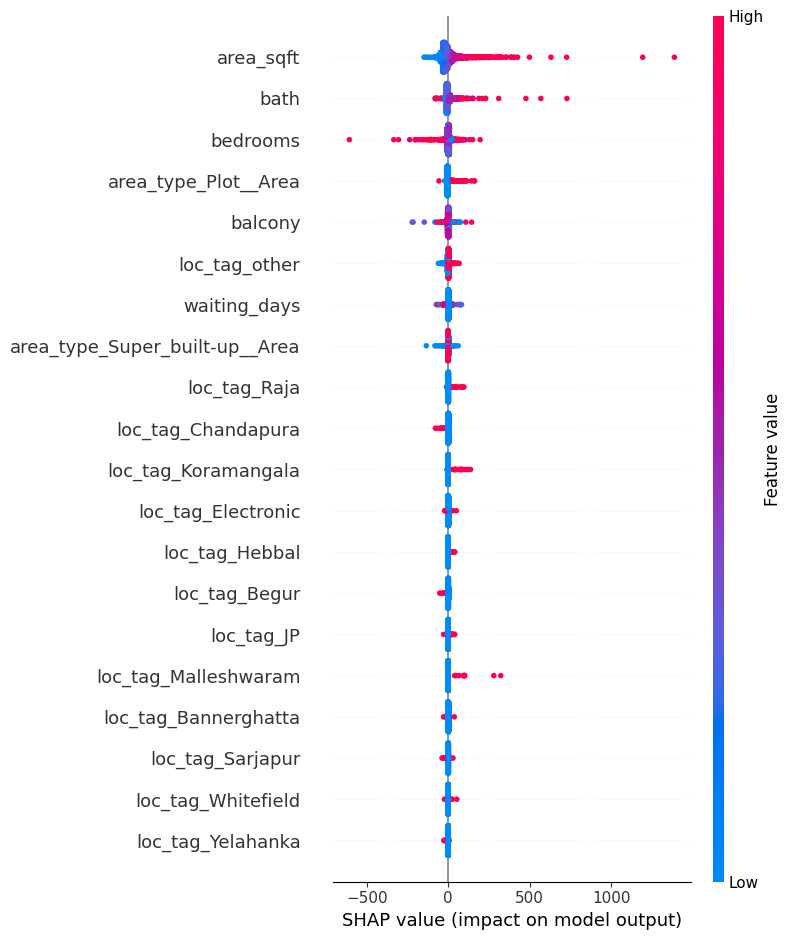

In [ ]:
shap.summary_plot(shap_values)

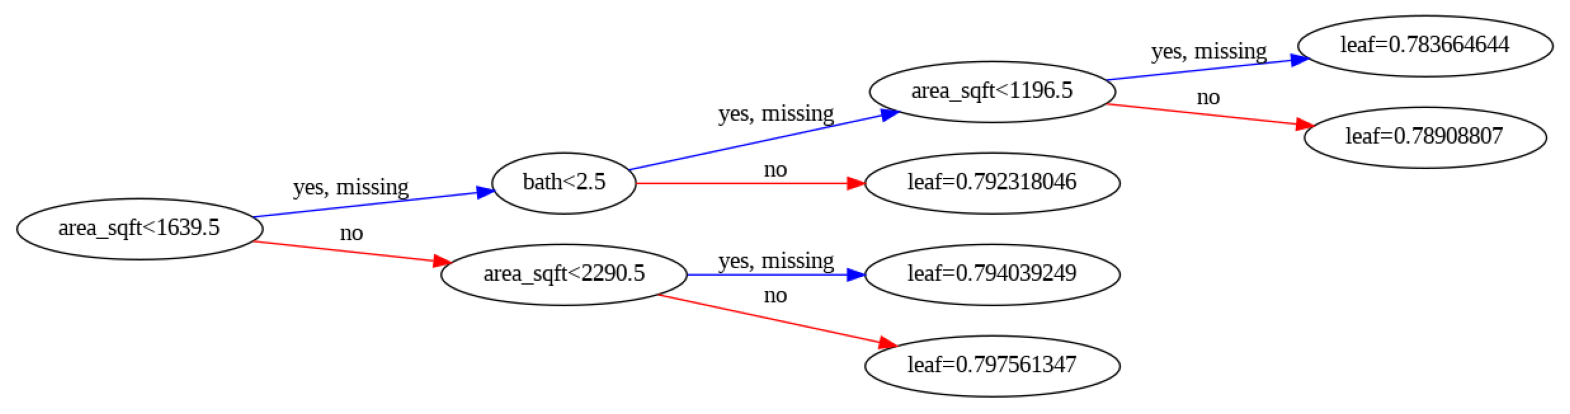

In [ ]:
from xgboost import plot_tree
plot_tree(model, rankdir='LR')
#plt.rcParams['figure.figsize']=[50, 30]
plt.gcf().set_size_inches(20, 10)
plt.savefig("BLR_RealEstate.png")

We can nconclude that Random Forest Regression model gives the best  result in determining the price of those properties. It has an R_2 score of 0.676 which is pretty good in this case where we used genearlized approrach with top 30 locations. XGBoost Regression model gives the second best result in determining the price of those properties. It has an R_2 score of 0.6162 which is pretty good in this case. We can also see the price distribution curve and how smoothly it fits with actual curve in Random Forest Regression and XGBoost Regression model. Only in XGBoost Regression the prediicted price goes in line with the actual price.